In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import PolynomialFeatures

import matplotlib.pyplot as plt


/Users/varchitalalwani/miniconda3/envs/eolearn/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Loading data

In [2]:
df_train = pd.read_csv('train_users.csv')
df_test = pd.read_csv('test_users.csv')

In [3]:
df_train.shape

(2000, 6)

In [4]:
df_test.shape

(2000, 6)

# EDA

In [5]:


print(df_train.shape)
print(df_train.head(3))
print(df_train.dtypes)
print("\nUnique labels:", df_train["label"].unique())
print("\nLabel counts:\n", df_train["label"].value_counts())
print("\nLabel proportions:\n", df_train["label"].value_counts(normalize=True))


(2000, 6)
   user_id  age  income  clicks  purchase_amount  label
0        1   28   58242      81           378.38  user3
1        2   28   38225      21           114.50  user3
2        3   39   95017      41            66.24  user2
user_id              int64
age                  int64
income               int64
clicks               int64
purchase_amount    float64
label               object
dtype: object

Unique labels: ['user3' 'user2' 'user1']

Label counts:
 label
user1    687
user2    669
user3    644
Name: count, dtype: int64

Label proportions:
 label
user1    0.3435
user2    0.3345
user3    0.3220
Name: proportion, dtype: float64


In [6]:
print("\nMissing values per column:\n", df_train.isna().sum())
print("\nDuplicate rows:", df_train.duplicated().sum())
print("Duplicate user_id:", df_train["user_id"].duplicated().sum() if "user_id" in df_train.columns else "no user_id col")



Missing values per column:
 user_id            0
age                0
income             0
clicks             0
purchase_amount    0
label              0
dtype: int64

Duplicate rows: 0
Duplicate user_id: 0


In [7]:
feat_cols = [c for c in df_train.columns if c not in ["user_id", "label"]]


In [8]:
print("\nPer-class mean:\n", df_train.groupby("label")[feat_cols].mean())
print("\nPer-class std:\n", df_train.groupby("label")[feat_cols].std())

q = df_train.groupby("label")[feat_cols].quantile([0.1, 0.5, 0.9])
print("\nPer-class quantiles (0.1/0.5/0.9):\n", q)



Per-class mean:
              age        income     clicks  purchase_amount
label                                                     
user1  38.282387  59970.538574  47.892285       250.827889
user2  37.738416  62085.587444  50.115097       247.906981
user3  37.683230  59732.678571  47.729814       258.299394

Per-class std:
              age        income     clicks  purchase_amount
label                                                     
user1  11.897474  23235.930786  30.284078       146.473889
user2  12.313594  23333.186983  29.298386       137.422191
user3  11.848800  22845.180267  28.760528       145.308194

Per-class quantiles (0.1/0.5/0.9):
             age   income  clicks  purchase_amount
label                                            
user1 0.1  22.0  27694.0     6.0           49.160
      0.5  38.0  60437.0    49.0          253.310
      0.9  55.0  93077.6    90.0          451.246
user2 0.1  21.0  29493.2     7.0           65.880
      0.5  37.0  62184.0    50.0      

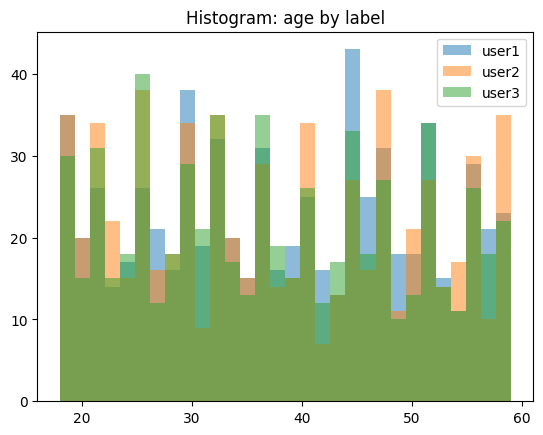

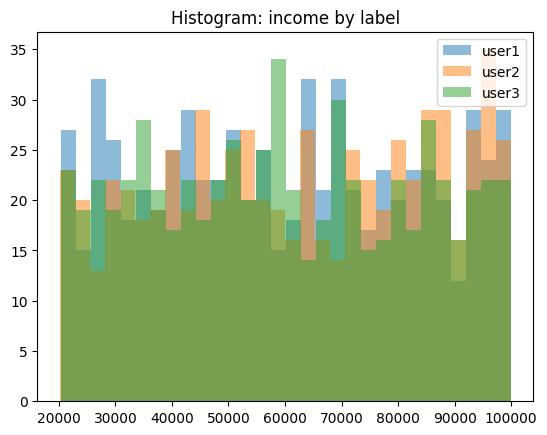

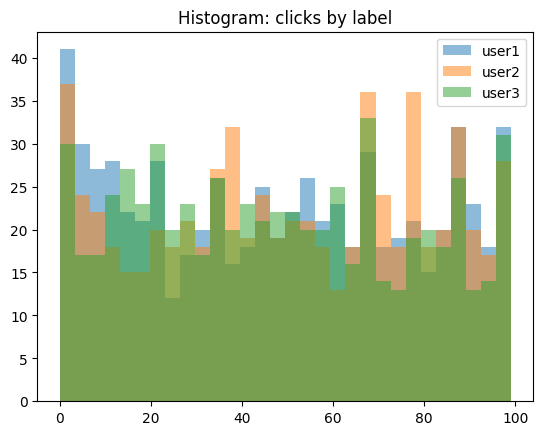

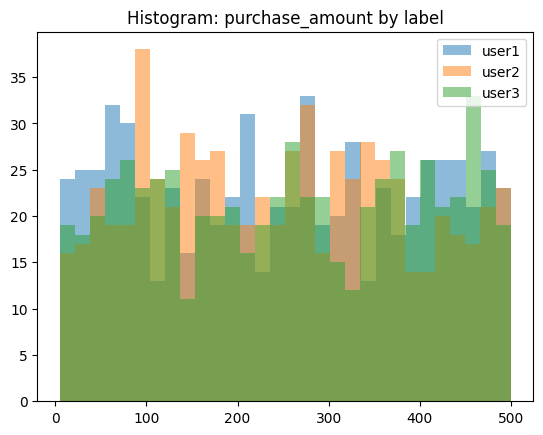

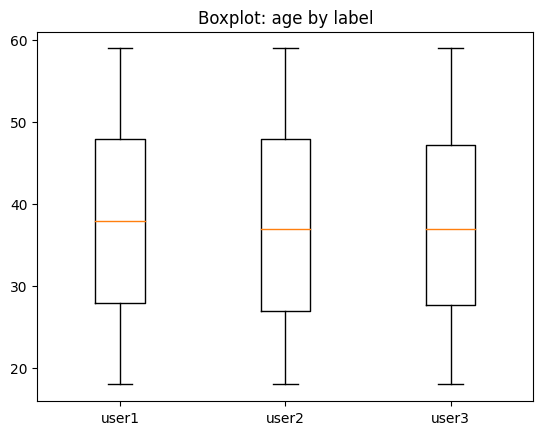

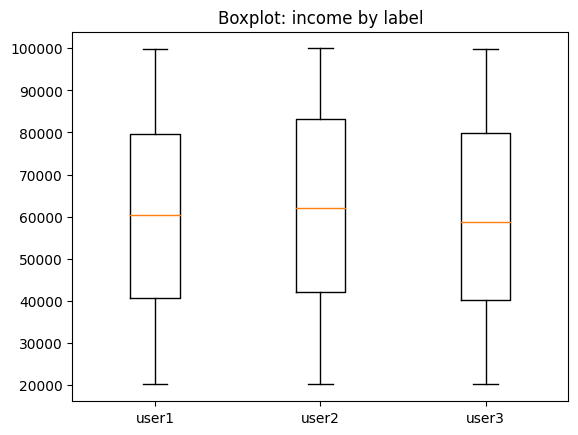

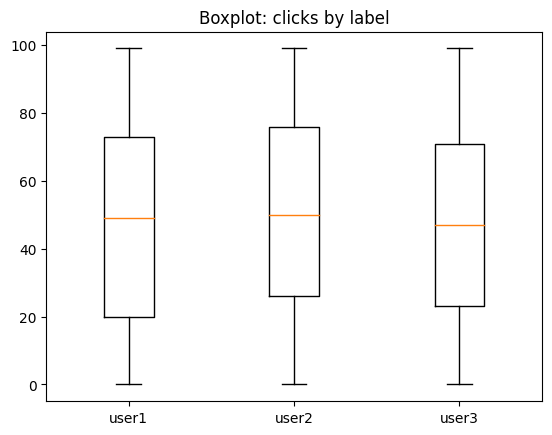

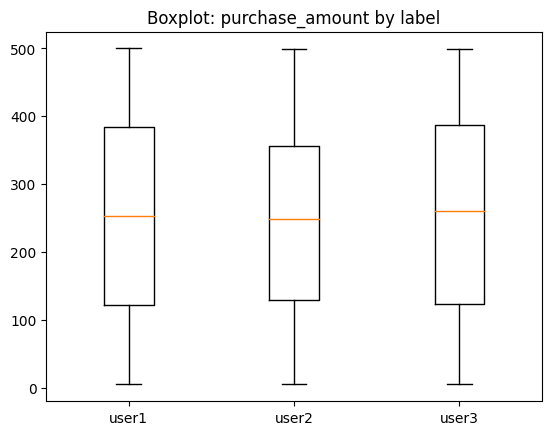

In [9]:
feat_cols = [c for c in df_train.columns if c not in ["user_id", "label"]]

for c in feat_cols:
    plt.figure()
    for lab, sub in df_train.groupby("label"):
        plt.hist(sub[c].dropna(), bins=30, alpha=0.5, label=lab)
    plt.title(f"Histogram: {c} by label")
    plt.legend()
    plt.show()

for c in feat_cols:
    plt.figure()
    data = [df_train[df_train["label"]==lab][c].dropna() for lab in sorted(df_train["label"].unique())]
    plt.boxplot(data, labels=sorted(df_train["label"].unique()))
    plt.title(f"Boxplot: {c} by label")
    plt.show()


On average, the three user categories look very similar in feature space. This indicates weak linear separability and suggests any classifier will struggle. The class distributions overlap heavily. The signal (between-class difference) is much smaller than the noise (within-class spread), which explains why DT/RF/LR all converge near chance. Even across the distribution (not just mean), the classes overlap strongly. This suggests that increasing model complexity alone (e.g., RandomForest, SVM, MLP) will not reliably improve beyond ~33–38%, because the features do not form distinct class clusters.


Correlation matrix:
                       age    income    clicks  purchase_amount
age              1.000000  0.028278  0.005059         0.021404
income           0.028278  1.000000 -0.003767        -0.035976
clicks           0.005059 -0.003767  1.000000         0.007151
purchase_amount  0.021404 -0.035976  0.007151         1.000000


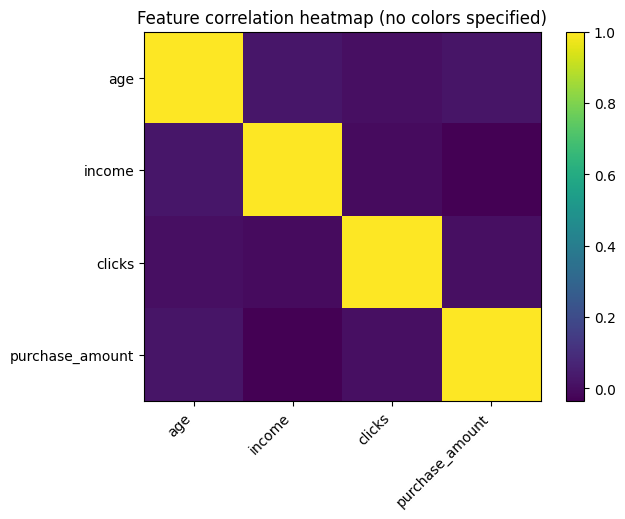

In [10]:
corr = df_train[feat_cols].corr(numeric_only=True)
print("\nCorrelation matrix:\n", corr)

plt.figure()
plt.imshow(corr, aspect="auto")
plt.xticks(range(len(feat_cols)), feat_cols, rotation=45, ha="right")
plt.yticks(range(len(feat_cols)), feat_cols)
plt.title("Feature correlation heatmap (no colors specified)")
plt.colorbar()
plt.show()


The correlation analysis suggests that the provided numeric features (age, income, clicks, purchase_amount) do not contain strong internal structure or dependency patterns. Along with heavy overlap of feature distributions across labels, this indicates that predicting user1/user2/user3 from these features alone is intrinsically difficult, leading to performance close to random chance.

# Results with no extra features, 5-fold CV

In [11]:
X_test  = df_test[feat_cols]

In [12]:
X = df_train[feat_cols]
y = df_train["label"].astype(str)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

prep_tree = ColumnTransformer(
    [("num", SimpleImputer(strategy="median"), feat_cols)],
    remainder="drop"
)

prep_scaled = ColumnTransformer(
    [("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), feat_cols)],
    remainder="drop"
)

models = {
    "DecisionTree": Pipeline([
        ("prep", prep_tree),
        ("clf", DecisionTreeClassifier(random_state=42, class_weight="balanced"))
    ]),
    "RandomForest": Pipeline([
        ("prep", prep_tree),
        ("clf", RandomForestClassifier(
            n_estimators=800,
            random_state=42,
            class_weight="balanced_subsample",
            n_jobs=-1
        ))
    ]),
    "HistGradientBoosting": Pipeline([
        ("prep", prep_tree),
        ("clf", HistGradientBoostingClassifier(
            max_depth=6, learning_rate=0.05, max_iter=800, random_state=42
        ))
    ]),
    "LogisticRegression": Pipeline([
        ("prep", prep_scaled),
        ("clf", LogisticRegression(
            max_iter=5000,
            class_weight="balanced",
            n_jobs=-1
        ))
    ]),
    "SVM_RBF": Pipeline([
        ("prep", prep_scaled),
        ("clf", SVC(
            kernel="rbf",
            C=10,
            gamma="scale",
            class_weight="balanced"
        ))
    ]),
    "MLP": Pipeline([
        ("prep", prep_scaled),
        ("clf", MLPClassifier(
            hidden_layer_sizes=(64, 64),
            alpha=1e-4,
            max_iter=1000,
            random_state=42
        ))
    ]),
}

scoring = {
    "acc": "accuracy",
    "macro_f1": "f1_macro"
}

rows = []
for name, model in models.items():
    out = cross_validate(
        model, X, y,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False
    )
    acc_mean, acc_std = out["test_acc"].mean(), out["test_acc"].std()
    f1_mean, f1_std = out["test_macro_f1"].mean(), out["test_macro_f1"].std()

    rows.append([name, acc_mean, acc_std, f1_mean, f1_std])

results = pd.DataFrame(rows, columns=["model", "acc_mean", "acc_std", "macroF1_mean", "macroF1_std"])
results = results.sort_values("acc_mean", ascending=False)

print(results.to_string(index=False))


/Users/varchitalalwani/miniconda3/envs/eolearn/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/varchitalalwani/miniconda3/envs/eolearn/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/varchitalalwani/miniconda3/envs/eolearn/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/varchitalalwani/miniconda3/envs/eolearn/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/varchitalalwa

               model  acc_mean  acc_std  macroF1_mean  macroF1_std
HistGradientBoosting    0.3560 0.029309      0.355378     0.029414
                 MLP    0.3485 0.026627      0.344527     0.026232
             SVM_RBF    0.3470 0.020761      0.345220     0.020863
  LogisticRegression    0.3430 0.027722      0.339249     0.027988
        DecisionTree    0.3380 0.014782      0.337448     0.014856
        RandomForest    0.3360 0.028399      0.335634     0.028161


In [13]:
models.keys()

dict_keys(['DecisionTree', 'RandomForest', 'HistGradientBoosting', 'LogisticRegression', 'SVM_RBF', 'MLP'])

In [14]:
X_train = df_train[feat_cols]
y_train = df_train["label"].astype(str)

X_test  = df_test[feat_cols]

for m in models.keys():
    print("\nModel Name:", m)
    print("=======================================================")
    best_model = models[m]   

    # full train
    best_model.fit(X_train, y_train)

    # Predict on test
    test_pred = best_model.predict(X_test)

    if "label" in df_test.columns and df_test["label"].notna().all():
        y_test = df_test["label"].astype(str)
        acc = accuracy_score(y_test, test_pred)
        mf1 = f1_score(y_test, test_pred, average="macro")
        wf1 = f1_score(y_test, test_pred, average="weighted")

        print("\nTEST accuracy:", acc)
        print("TEST macro-F1:", mf1)
        print("TEST weighted-F1:", wf1)
        print("\nConfusion matrix:\n", confusion_matrix(y_test, test_pred))
        print("\nReport:\n", classification_report(y_test, test_pred))





Model Name: DecisionTree

TEST accuracy: 0.3155
TEST macro-F1: 0.3156485836172221
TEST weighted-F1: 0.3155862996543084

Confusion matrix:
 [[199 237 236]
 [255 221 203]
 [228 210 211]]

Report:
               precision    recall  f1-score   support

       user1       0.29      0.30      0.29       672
       user2       0.33      0.33      0.33       679
       user3       0.32      0.33      0.32       649

    accuracy                           0.32      2000
   macro avg       0.32      0.32      0.32      2000
weighted avg       0.32      0.32      0.32      2000


Model Name: RandomForest

TEST accuracy: 0.3265
TEST macro-F1: 0.32663338666383546
TEST weighted-F1: 0.32649198993307943

Confusion matrix:
 [[219 234 219]
 [252 215 212]
 [218 212 219]]

Report:
               precision    recall  f1-score   support

       user1       0.32      0.33      0.32       672
       user2       0.33      0.32      0.32       679
       user3       0.34      0.34      0.34       649

    acc

# Adding features

In [15]:


def add_features(df):
    df = df.copy()
    
    df["log_income"]   = np.log1p(df["income"])
    df["log_clicks"]   = np.log1p(df["clicks"])
    df["log_purchase"] = np.log1p(df["purchase_amount"])

    
    df["purchase_per_click"]   = df["purchase_amount"] / (df["clicks"] + 1.0)
    df["clicks_per_income"]    = df["clicks"] / (df["income"] + 1.0)
    df["purchase_per_income"]  = df["purchase_amount"] / (df["income"] + 1.0)

    
    df["age_x_clicks"]         = df["age"] * df["clicks"]
    df["income_x_clicks"]      = df["income"] * df["clicks"]
    df["income_x_purchase"]    = df["income"] * df["purchase_amount"]
    return df

train2 = add_features(df_train)
test2  = add_features(df_test)

target = "label"
drop_cols = ["user_id", target]
feat_cols = [c for c in train2.columns if c not in drop_cols]

Xtr, ytr = train2[feat_cols], train2[target]
Xte, yte = test2[feat_cols],  test2[target]


In [16]:

prep = ColumnTransformer([("num", SimpleImputer(strategy="median"), feat_cols)])

hgb = Pipeline([
    ("prep", prep),
    ("clf", HistGradientBoostingClassifier(
        max_depth=6,
        learning_rate=0.05,
        max_iter=1200,
        random_state=42
    ))
])

hgb.fit(Xtr, ytr)
pred = hgb.predict(Xte)

print("HGB acc:", accuracy_score(yte, pred))
print("HGB macroF1:", f1_score(yte, pred, average="macro"))


HGB acc: 0.3355
HGB macroF1: 0.33562573343508834


In [17]:


svm = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc", StandardScaler()),
    ("clf", SVC(
        kernel="rbf",
        C=10,                # try 1, 10, 50
        gamma="scale",
        class_weight="balanced"
    ))
])

svm.fit(Xtr, ytr)
pred = svm.predict(Xte)

print("SVM acc:", accuracy_score(yte, pred))
print("SVM macroF1:", f1_score(yte, pred, average="macro"))


SVM acc: 0.322
SVM macroF1: 0.31705930150958334


In [18]:
for C in [0.5, 1, 5, 10, 25, 50]:
    svm.set_params(clf__C=C)
    svm.fit(Xtr, ytr)
    pred = svm.predict(Xte)
    print(C, accuracy_score(yte, pred))


0.5 0.326
1 0.3205
5 0.315
10 0.322
25 0.325
50 0.321


In [19]:


mlp = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc", StandardScaler()),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(64, 64),
        alpha=1e-4,
        max_iter=800,
        random_state=42
    ))
])

mlp.fit(Xtr, ytr)
pred = mlp.predict(Xte)

print("MLP acc:", accuracy_score(yte, pred))
print("MLP macroF1:", f1_score(yte, pred, average="macro"))


MLP acc: 0.3315
MLP macroF1: 0.33043482037384475
